# Model performance

After training all SVMs, we assess model performance using precision and recall of both outcome classes.

### Importing packages

In [19]:
import datetime
from itertools import product
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, average_precision_score

In [20]:
data_path = Path('../data')
results_path = Path('../testresults')

### Functions to read files created by 2_modeltraining.py and to plot results

In [21]:
def pretty_results(filenames, foldersuffix=''):
    reslist = []
    for index1, filename in enumerate(filenames):
        _, sex, nback = filename.split('_')
        res = pd.read_pickle(results_path / f'models{foldersuffix}' / f'{filename}.pkl')
        for index2, cr in enumerate(res):
            traintest = ['train', 'test'][index2 % 2]
            reslist.append([nback, traintest, sex, cr['0']['precision'], cr['0']['recall'], cr['0']['support'],
                            cr['1']['precision'], cr['1']['recall'], cr['1']['support']])
    res = pd.DataFrame(reslist).set_axis(['nback', 'traintest', 'sex', 'ok_precision', 'ok_recall', 'ok_support',
                                          'low_precision', 'low_recall', 'low_support'], axis=1)
    return res
    
def get_scores(res_df):
    res_df['old_defrate'] = res_df['low_support'] / (res_df['low_support'] + res_df['ok_support'])
    res_df['new_defrate'] = 1 - res_df['ok_precision']
    res_df['missed_dons'] = 1 - res_df['ok_recall']
    res_df['prevented_defs'] = res_df['low_recall']
    res_df['missed_per_prev'] = (res_df['ok_support'] - res_df['ok_recall'] * res_df['ok_support']) / (res_df['low_support'] - (1 - res_df['ok_precision']) * res_df['ok_support'])
    
    res_df['old_def_n'] = res_df['low_support']
    res_df['new_def_n'] = round((1 - res_df['ok_precision']) * res_df['ok_support'])
    res_df['old_don_n'] = res_df['ok_support']
    res_df['new_don_n'] = res_df['ok_recall'] * res_df['ok_support']
    
    return res_df
 
def plot_precision_recall(res_df, measure, ylim, ylab, save=False):
    pl_df = res_df.groupby(['sex', 'traintest'])

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    for name, group in pl_df:
        y = 0 if name[0] == 'F' else 1
        off = -0.2 if name[1] == 'train' else 0.2
        hatch = '/' if name[1] == 'test' else ''
        ax[y].bar(group.nback + off, group[measure], label=name[1], width=0.4, edgecolor='black', hatch=hatch)
        ax[y].set_ylim(ylim)
        ax[y].set_xticks(group.nback)
        ax[y].set_xticklabels(['SVM-1','SVM-2','SVM-3','SVM-4','SVM-5'], size='large')
        ax[y].set_ylabel(ylab, size='large')
    
    legloc = 'upper right' if measure == 'low_precision' else 'lower right'
    legbox = (1, 1) if measure == 'low_precision' else (1, 0)
    ax[0].legend(labels=['train', 'test'], bbox_to_anchor=legbox, loc=legloc, title='Dataset')
    ax[1].legend(labels=['train', 'test'], bbox_to_anchor=legbox, loc=legloc, title='Dataset')
    
    ax[0].set_title('Women')
    ax[1].set_title('Men')

    fig.tight_layout()
    plt.set_cmap('tab20')
    
    if save:
        plot_path = results_path / 'plots_performance'
        plot_path.mkdir(parents=True, exist_ok=True)
        plt.savefig(plot_path / f'{save}.png')
    
    plt.show()
    
def plot_precision_recall_comp(res_df, measure, ylim, ylab, save=False):
    pl_df = res_df.loc[res_df['traintest'] == 'test'].groupby(['sex', 'vars'])

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    for name, group in pl_df:
        y = 0 if name[0] == 'F' else 1
        off = -0.2 if name[1] == 'all' else 0.2
        hatch = '/' if name[1] == 'all' else ''
        colr = 'deepskyblue' if name[1] == 'all' else 'rebeccapurple'
        ax[y].bar(group.nback + off, group[measure], label=name[1], width=0.4, edgecolor='black', 
                  hatch=hatch, color=colr)
        ax[y].set_ylim(ylim)
        ax[y].set_xticks(group.nback)
        ax[y].set_xticklabels(['SVM-1','SVM-2','SVM-3','SVM-4','SVM-5'], size='large')
        ax[y].set_ylabel(ylab, size='large')

    legloc = 'upper right' if measure == 'low_precision' else 'lower right'
    legbox = (1, 1) if measure == 'low_precision' else (1, 0)
    ax[0].legend(labels=['all', 'only Hb'], bbox_to_anchor=legbox, loc=legloc, title='Predictor\nvariables')
    ax[1].legend(labels=['all', 'only Hb'], bbox_to_anchor=legbox, loc=legloc, title='Predictor\nvariables')
    
    ax[0].set_title('Women')
    ax[1].set_title('Men')

    fig.tight_layout()
    
    if save:
        plot_path = results_path / 'plots_performance'
        plot_path.mkdir(parents=True, exist_ok=True)
        plt.savefig(plot_path / f'{save}.png')
    
    plt.show()

# Model performance of SVM using all predictor variables
## Precision and recall plots for both outcome classes
Note the zoomed-in y-axes for precision plots in order to see differences between models more clearly.

In [22]:
res_df = pretty_results([f'res_{sex}_{nback}' for sex in ['men','women'] for nback in range(1,6)])
res_df = get_scores(res_df)

In [23]:
res_df

nback traintest    sex  ok_precision  ok_recall  ok_support  low_precision  \
0      1     train    men      0.549793   0.585420        1358       0.617007   
1      1      test    men      0.516667   0.447653         277       0.562857   
2      2     train    men      0.563036   0.629985        1354       0.640603   
3      2      test    men      0.472119   0.458484         277       0.532710   
4      3     train    men      0.791298   0.794815        1350       0.820828   
5      3      test    men      0.477178   0.415162         277       0.535817   
6      4     train    men      0.841874   0.854383        1346       0.871812   
7      4      test    men      0.464286   0.422383         277       0.526627   
8      5     train    men      0.880597   0.879285        1342       0.895349   
9      5      test    men      0.478431   0.440433         277       0.537313   
10     1     train  women      0.364103   0.643505         331       0.823617   
11     1      test  women      0.296296   0.369231          65       0.751515   
12     2     train  women      1.000000   1.000000         329       1.000000   
13     2      test  women      0.000000   0.000000          65       0.735772   
14     3     train  women      0.283117   0.993921         329       0.978495   
15     3      test  women      0.265217   0.938462          65       0.750000   
16     4     train  women      1.000000   0.012158         329       0.738114   
17     4      test  women      0.000000   0.000000          65       0.735772   
18     5     train  women      1.000000   1.000000         328       1.000000   
19     5      test  women      0.000000   0.000000          65       0.735772   

    low_recall  low_support  old_defrate  new_defrate  missed_dons  \
0     0.582157         1558     0.534294     0.450207     0.414580   
1     0.629393          313     0.530508     0.483333     0.552347   
2     0.574277         1555     0.534548     0.436964     0.370015   
3     0.546326          313     0.530508     0.527881     0.541516   
4     0.817655         1552     0.534804     0.208702     0.205185   
5     0.597444          313     0.530508     0.522822     0.584838   
6     0.860555         1549     0.535060     0.158126     0.145617   
7     0.568690          313     0.530508     0.535714     0.577617   
8     0.896507         1546     0.535319     0.119403     0.120715   
9     0.575080          313     0.530508     0.521569     0.559567   
10    0.596966          923     0.736045     0.635897     0.356495   
11    0.685083          181     0.735772     0.703704     0.630769   
12    1.000000          922     0.737010     0.000000     0.000000   
13    1.000000          181     0.735772     1.000000     1.000000   
14    0.099021          919     0.736378     0.716883     0.006079   
15    0.066298          181     0.735772     0.734783     0.061538   
16    1.000000          916     0.735743     0.000000     0.987842   
17    1.000000          181     0.735772     1.000000     1.000000   
18    1.000000          914     0.735910     0.000000     0.000000   
19    1.000000          181     0.735772     1.000000     1.000000   

    prevented_defs  missed_per_prev  old_def_n  new_def_n  old_don_n  \
0         0.582157         0.594749       1558      611.0       1358   
1         0.629393         0.854192        313      134.0        277   
2         0.574277         0.520060       1555      592.0       1354   
3         0.546326         0.899405        313      146.0        277   
4         0.817655         0.218067       1552      282.0       1350   
5         0.597444         0.963263        313      145.0        277   
6         0.860555         0.146689       1549      213.0       1346   
7         0.568690         0.972011        313      148.0        277   
8         0.896507         0.116903       1546      160.0       1342   
9         0.575080         0.919742        313      144.0        277   
10        0.596966         0.165610   

In [ ]:
plot_precision_recall(res_df, 'ok_precision', (0.95, 1), 'Precision\nclass no deferral', save='all_ok_precision')
plot_precision_recall(res_df, 'ok_recall', (0, 1), 'Recall\nclass no deferral', save='all_ok_recall')
plot_precision_recall(res_df, 'low_precision', (0, 0.15), 'Precision\nclass deferral', 'all_low_precision')
plot_precision_recall(res_df, 'low_recall', (0, 1), 'Recall\nclass deferral', save='all_low_recall')

## Precision-recall curve
The PR curve shows the precision and recall at different probability thresholds for classification. This is more informative than a ROC curve because of the imbalanced outcome classes. A perfect classifier would have a precision of 1 for every recall value, so would look like a horizontal line at y=1. The area under the PR curve (AUPR) is a performance metric between 0 and 1 that indicates the quality of the classifier.  

### Functions to load probabilities and plot PR curves

In [32]:
def load_probas(sexes=('men', 'women'), path=results_path / 'probas', nbacks=range(1, 6)):
    dfs = []
    for sex, nback in product(sexes, nbacks):
        df = pd.read_pickle(path / f'proba_{sex}_{nback}.pkl')
        df['sex'] = sex
        df['nback'] = nback
        dfs.append(df)
    return pd.concat(dfs)

def plot_prs(probas, (def_f, def_m), save=False):
    fig, ax = plt.subplots(2, 2, figsize=(10,10))
    
    for x, sex in enumerate(['men', 'women']):
        df = probas.loc[probas['sex'] == sex, ]
        
        for key, group in df.groupby('nback'):
            precision_0, recall_0, thresholds_0 = precision_recall_curve(group.HbOK, group.prob_low, pos_label=0)
            precision_1, recall_1, thresholds_1 = precision_recall_curve(group.HbOK, group.prob_ok, pos_label=1)
            
            aupr_0 = round(average_precision_score(group.HbOK, group.prob_low, pos_label=0), 3)
            aupr_1 = round(average_precision_score(group.HbOK, group.prob_ok, pos_label=1), 3)

            ax[1,x].plot(recall_0, precision_0, label='SVM-'+str(key)+', AUPR: '+str(aupr_0))
            ax[0,x].plot(recall_1, precision_1, label='SVM-'+str(key)+', AUPR: '+str(aupr_1))
        
        ax[0,x].set_title('PR-curve class deferral - ' + ['men', 'women'][x])
        ax[0,x].set_xlabel('Recall')
        ax[0,x].set_ylabel('Precision')
        ax[1,x].set_title('PR-curve class no deferral - ' + ['men', 'women'][x])
        ax[1,x].set_xlabel('Recall')
        ax[1,x].set_ylabel('Precision')
        ax[0,x].legend(loc='upper right')
        ax[1,x].legend(loc='lower left')
        ax[0,x].set_ylim(0,0.5)
    
    #horizontal lines for baseline
    ax[0,0].hlines(y=def_m, xmin=0, xmax=1, color='grey', ls='--')
    ax[1,0].hlines(y=1-def_m, xmin=0, xmax=1, color='grey', ls='--')
    ax[0,1].hlines(y=def_f, xmin=0, xmax=1, color='grey', ls='--')
    ax[1,1].hlines(y=1-def_f, xmin=0, xmax=1, color='grey', ls='--')
    
    if save:
        plot_path = results_path / 'plots_performance/'
        plot_path.mkdir(parents=True, exist_ok=True)
        plt.savefig(plot_path / f'{save}.png')
    
    plt.show()

First, predictions are made on the test set again, now storing the probability of each observation belonging to each outcome class. We also calculate the proportion of observations belonging to each class (true outcome), as these are the baseline values for the AUPR (the AUPR obtained by a classifier predicting only the majority class).

In [33]:
sexes = ['men', 'women']
nbacks = range(1, 6)

for sex, nback in product(sexes, nbacks):
    print(datetime.datetime.now(), 'Starting', nback, sex)
    
    clf = pickle.load(open(results_path / f'models/clf_{sex}_{nback}.sav', 'rb'))
    test = pd.read_pickle(data_path / f'scaled/{sex}_{nback}_test.pkl')
    y_true = test[test.columns[-1:]].copy()
    y_pred = clf.predict_proba(test[test.columns[:-1]])
    y_true[['prob_low', 'prob_ok']] = y_pred
    
    pickle.dump(y_true, open(results_path / f'proba_{sex}_{nback}.pkl', 'wb'))
    
proba_m = pd.read_pickle(results_path / 'probas/proba_men_1.pkl')
proba_f = pd.read_pickle(results_path / 'probas/proba_women_1.pkl')
def_m = 1-np.mean(proba_m.HbOK)
def_f = 1-np.mean(proba_f.HbOK)

### PR curve 
PR curves for men and women, shown for each of the 5 SVMs. AUPR values are given in the legend. The grey dashed line indicates the baseline.

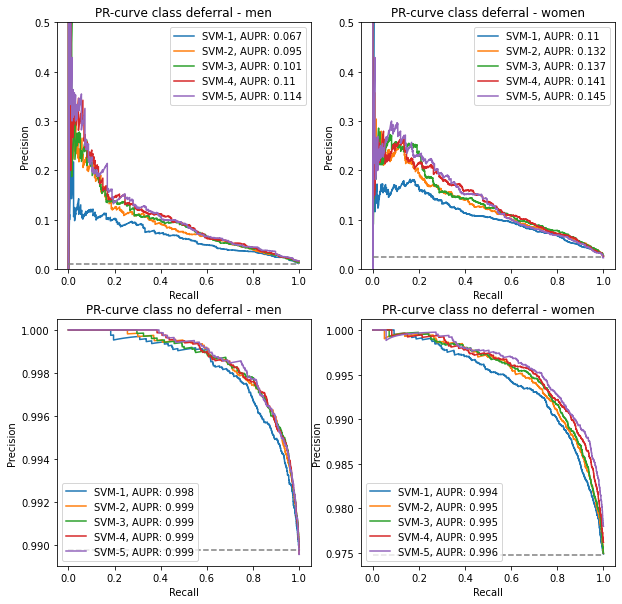

In [34]:
probas = load_probas()
plot_prs(probas, (def_f, def_m), save='PR_curve')

# Model performance of SVM using only Hb variables

In [ ]:
res_df_onlyhb = pretty_results([f'res_{sex}_{nback}' for sex in ['men','women'] for nback in range(1,6)], foldersuffix='_onlyhb')
res_df_onlyhb = get_scores(res_df_onlyhb)

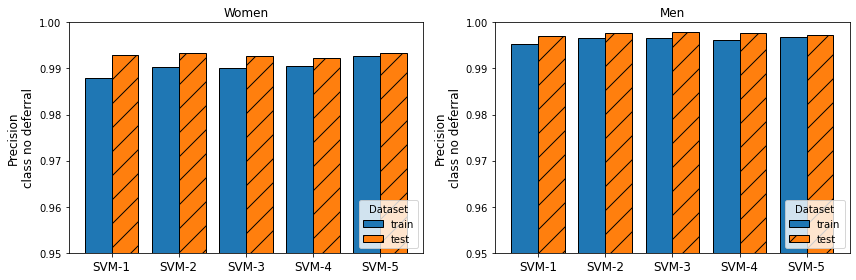

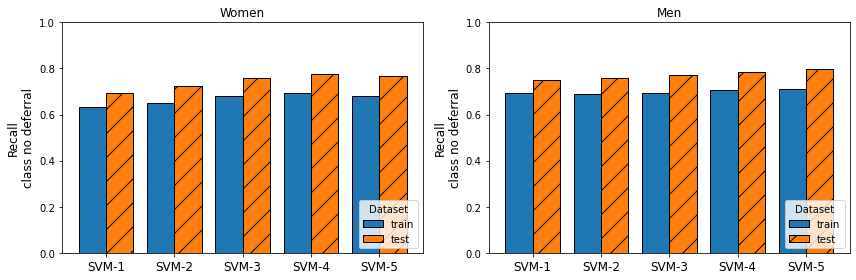

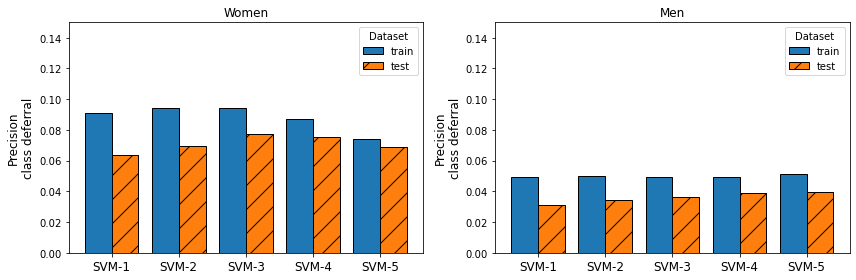

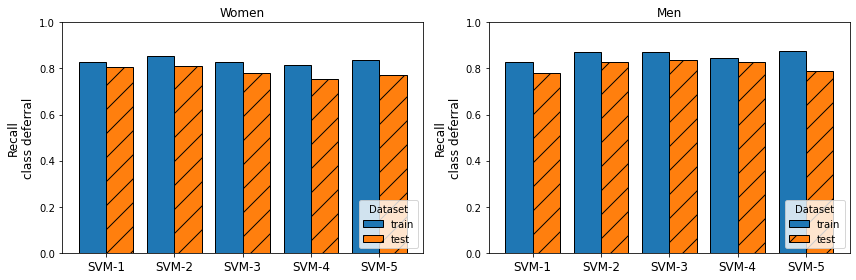

In [30]:
plot_precision_recall(res_df_onlyhb, 'ok_precision', (0.95, 1), 'Precision\nclass no deferral', save='onlyhb_ok_precision')
plot_precision_recall(res_df_onlyhb, 'ok_recall', (0, 1), 'Recall\nclass no deferral', save='onlyhb_ok_recall')
plot_precision_recall(res_df_onlyhb, 'low_precision', (0, 0.15), 'Precision\nclass deferral', save='onlyhb_low_precision')
plot_precision_recall(res_df_onlyhb, 'low_recall', (0, 1), 'Recall\nclass deferral', save='onlyhb_low_recall')

# Comparing performance between all vars and only Hb vars
Showing only the performance on the test set

## Graphical comparison of precision and recall

In [9]:
res_df['vars'] = 'all'
res_df_onlyhb['vars'] = 'onlyhb'

res_tot = pd.concat([res_df, res_df_onlyhb])
res_tot.head()

nback trainval sex  ok_precision  ok_recall  ok_support  low_precision  \
0      1    train   M      0.995710   0.710088       66027       0.052189   
1      1      val   M      0.997475   0.760416       21817       0.034005   
2      1    train   F      0.986862   0.675056       60198       0.098655   
3      1      val   F      0.992535   0.732697       21051       0.070685   
4      2    train   M      0.996083   0.721028       55726       0.053919   

   low_recall  low_support  old_defrate  new_defrate  missed_dons  \
0    0.839172         1256     0.018667     0.004290     0.289912   
1    0.814159          226     0.010253     0.002525     0.239584   
2    0.798285         2682     0.042653     0.013138     0.324944   
3    0.786765          544     0.025191     0.007465     0.267303   
4    0.848659         1044     0.018390     0.003917     0.278972   

   prevented_defs  missed_per_prev  old_def_n  new_def_n  old_don_n  \
0        0.839172        19.678258       1256      283.0      66027   
1        0.814159        30.583963        226       55.0      21817   
2        0.798285        10.343641       2682      791.0      60198   
3        0.786765        14.545218        544      157.0      21051   
4        0.848659        18.827052       1044      218.0      55726   

   new_don_n vars  
0    46885.0  all  
1    16590.0  all  
2    40637.0  all  
3    15424.0  all  
4    40180.0  all

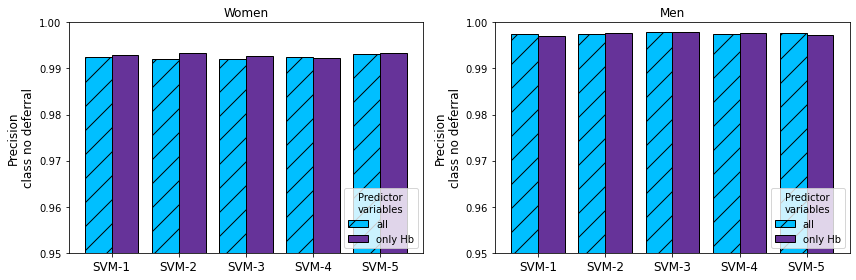

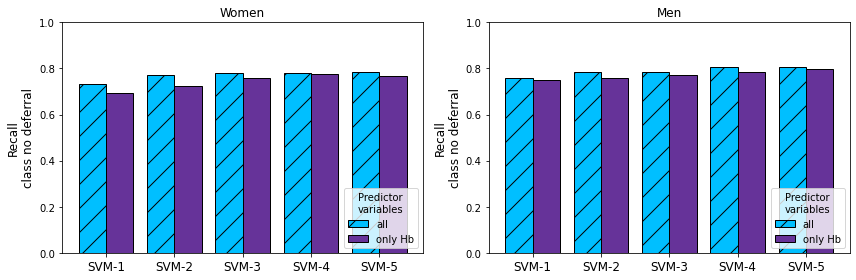

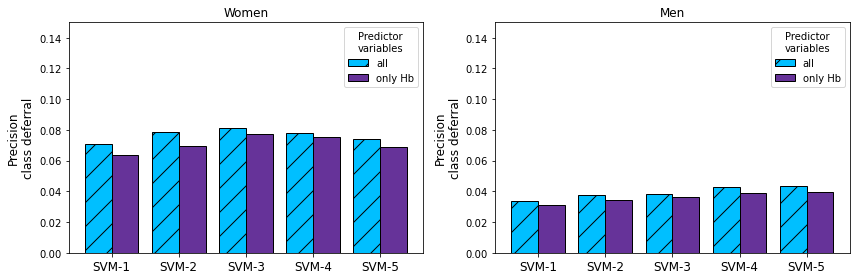

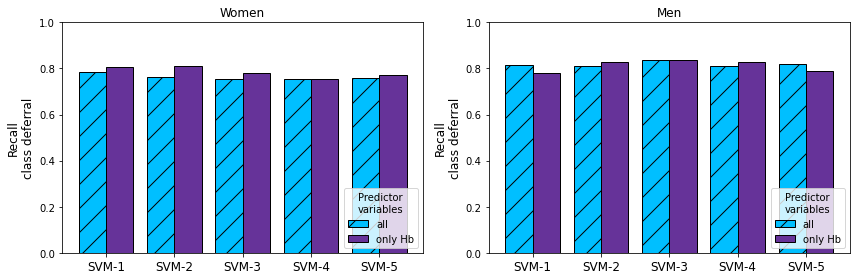

In [31]:
plot_precision_recall_comp(res_tot, 'ok_precision', (0.95, 1), 'Precision\nclass no deferral', save='compare_ok_precision')
plot_precision_recall_comp(res_tot, 'ok_recall', (0, 1), 'Recall\nclass no deferral', save='compare_ok_recall')
plot_precision_recall_comp(res_tot, 'low_precision', (0, 0.15), 'Precision\nclass deferral', save='compare_low_precision')
plot_precision_recall_comp(res_tot, 'low_recall', (0, 1), 'Recall\nclass deferral', save='compare_low_recall')

## Numerical comparison of performance measures
The diff column is calculated as (all vars) - (only Hb vars), so a positive difference indicates that the model with all variables performs better than the one with only Hb vars.

In [58]:
comp_res = res_tot.loc[res_tot['trainval'] == 'val', 
                       ['nback', 'sex', 
                        'ok_precision', 'ok_recall',
                        'low_precision', 'low_recall', 
                        'vars']].pivot(index=['nback', 'sex'], columns='vars')

comp_res['ok_precision', 'diff'] = comp_res['ok_precision', 'all'] - comp_res['ok_precision', 'onlyhb']
comp_res['ok_recall', 'diff'] = comp_res['ok_recall', 'all'] - comp_res['ok_recall', 'onlyhb']
comp_res['low_precision', 'diff'] = comp_res['low_precision', 'all'] - comp_res['low_precision', 'onlyhb']
comp_res['low_recall', 'diff'] = comp_res['low_precision', 'all'] - comp_res['low_precision', 'onlyhb']

comp_res

ok_precision           ok_recall           low_precision            \
vars               all    onlyhb       all    onlyhb           all    onlyhb   
nback sex                                                                      
1     F       0.992535  0.992870  0.732697  0.694599      0.070685  0.063920   
      M       0.997475  0.996946  0.760416  0.748178      0.034005  0.031041   
2     F       0.992108  0.993268  0.770882  0.722368      0.078743  0.069760   
      M       0.997511  0.997665  0.786045  0.758162      0.037605  0.034135   
3     F       0.991993  0.992672  0.781890  0.760764      0.081532  0.077351   
      M       0.997844  0.997809  0.782642  0.770272      0.038272  0.036286   
4     F       0.992391  0.992316  0.782464  0.774860      0.078046  0.075610   
      M       0.997557  0.997678  0.808159  0.784819      0.042785  0.038976   
5     F       0.993159  0.993330  0.785540  0.765521      0.073890  0.069012   
      M       0.997669  0.997239  0.807755  0.798479      0.043210  0.039825   

          low_recall           ok_precision ok_recall low_precision low_recall  
vars             all    onlyhb         diff      diff          diff       diff  
nback sex                                                                       
1     F     0.786765  0.806985    -0.000335  0.038098      0.006766   0.006766  
      M     0.814159  0.778761     0.000529  0.012238      0.002964   0.002964  
2     F     0.761538  0.809615    -0.001160  0.048514      0.008984   0.008984  
      M     0.809955  0.828054    -0.000154  0.027883      0.003470   0.003470  
3     F     0.754167  0.781250    -0.000679  0.021126      0.004180   0.004180  
      M     0.836449  0.836449     0.000035  0.012371      0.001986   0.001986  
4     F     0.754258  0.754258     0.000074  0.007604      0.002437   0.002437  
      M     0.812500  0.826923    -0.000121  0.023340      0.003809   0.003809  
5     F     0.759760  0.771772    -0.000171  0.020019      0.004878   0.004878  
      M     0.821429  0.790816     0.000430  0.009275      0.003385   0.003385

## Comparing precision-recall curves
Classifying observations in the test set again for the models using only Hb variables, now saving probability of deferral as determined by SVM in order to plot PR-curves. Baseline (deferral rate) is the same as for SVMs using all predictor variables.

In [ ]:
for nback in range(1,6):
    file_clf = '../results/models_onlyhb/clf_' + str(nback) + '.sav'
    clfs = pickle.load(open(file_clf, 'rb'))
    for index, sex in enumerate(['men', 'women']):
        #print(datetime.datetime.now(), 'Starting', nback, sex)
        clf = clfs[index]
        test = pd.read_pickle('../../data/scaled_onlyhb/'+str(sex)+'_'+str(nback)+'_test.pkl') 
        y_true = test[test.columns[-1:]].copy()
        y_pred = clf.predict_proba(test[test.columns[:-1]])
        y_true[['prob_low', 'prob_ok']] = y_pred
        file_preds = '../results/probas_onlyhb/proba_' + sex + '_' + str(nback) + '.pkl'
        pickle.dump(y_true, open(file_preds, 'wb'))

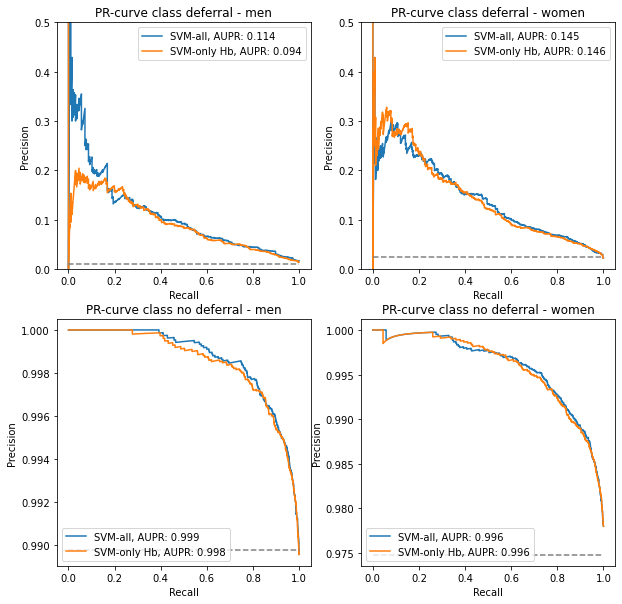

In [83]:
probas_onlyhb = load_probas(path='../results/probas_onlyhb/proba_')
probas['vars'] = 'all'
probas_onlyhb['vars'] = 'only Hb'

probas_all = pd.concat([probas, probas_onlyhb])
probas_5 = probas_all.loc[probas_all.nback == 5, ]

fig, ax = plt.subplots(2, 2, figsize=(10,10))

for x, sex in enumerate(['men', 'women']):
    df = probas_5.loc[probas_5['sex'] == sex, ]

    for key, group in df.groupby('vars'):
        precision_0, recall_0, thresholds_0 = precision_recall_curve(group.Hb_deferral, group.prob_low, pos_label=0)
        precision_1, recall_1, thresholds_1 = precision_recall_curve(group.Hb_deferral, group.prob_ok, pos_label=1)

        aupr_0 = round(average_precision_score(group.Hb_deferral, group.prob_low, pos_label=0), 3)
        aupr_1 = round(average_precision_score(group.Hb_deferral, group.prob_ok, pos_label=1), 3)

        ax[1,x].plot(recall_0, precision_0, label='SVM-'+str(key)+', AUPR: '+str(aupr_0))
        ax[0,x].plot(recall_1, precision_1, label='SVM-'+str(key)+', AUPR: '+str(aupr_1))

    ax[0,x].set_title('PR-curve class deferral - ' + ['men', 'women'][x])
    ax[0,x].set_xlabel('Recall')
    ax[0,x].set_ylabel('Precision')
    ax[1,x].set_title('PR-curve class no deferral - ' + ['men', 'women'][x])
    ax[1,x].set_xlabel('Recall')
    ax[1,x].set_ylabel('Precision')
    ax[0,x].legend(loc='upper right')
    ax[1,x].legend(loc='lower left')
    ax[0,x].set_ylim(0,0.5)

#horizontal lines for baseline
ax[0,0].hlines(y=def_m, xmin=0, xmax=1, color='grey', ls='--')
ax[1,0].hlines(y=1-def_m, xmin=0, xmax=1, color='grey', ls='--')
ax[0,1].hlines(y=def_f, xmin=0, xmax=1, color='grey', ls='--')
ax[1,1].hlines(y=1-def_f, xmin=0, xmax=1, color='grey', ls='--')

plt.savefig('../results/plots_performance/compare_PR_curve.png')

plt.show()

### Calculate and save probas of hbgen run

In [5]:
for nback in range(1,6):
    file_clf = '../results/models_hbgen/clf_' + str(nback) + '.sav'
    clfs = pickle.load(open(file_clf, 'rb'))
    for index, sex in enumerate(['men', 'women']):
        print(datetime.datetime.now(), 'Starting', nback, sex)
        clf = clfs[index]
        test = pd.read_pickle('../../data/scaled_hbgen/'+str(sex)+'_'+str(nback)+'_test.pkl') 
        y_true = test[test.columns[-1:]].copy()
        y_pred = clf.predict_proba(test[test.columns[:-1]])
        y_true[['prob_low', 'prob_ok']] = y_pred
        file_preds = '../results/probas_hbgen/proba_' + sex + '_' + str(nback) + '.pkl'
        pickle.dump(y_true, open(file_preds, 'wb'))

2022-07-01 06:29:38.887804 Starting 1 men
2022-07-01 06:30:48.596346 Starting 1 women
2022-07-01 06:31:59.636829 Starting 2 men
2022-07-01 06:33:00.377401 Starting 2 women
2022-07-01 06:33:49.857324 Starting 3 men
2022-07-01 06:34:41.499955 Starting 3 women
2022-07-01 06:35:15.785766 Starting 4 men
2022-07-01 06:35:51.333822 Starting 4 women
2022-07-01 06:36:17.793598 Starting 5 men
2022-07-01 06:37:01.170910 Starting 5 women
